Kinematics
=========

The [kinematics](api/ktk.kinematics) module allows opening trajectories of markers from c3d or n3d
files, and process those trajectory to:
- create rigid body configurations based on a static acquisitions;
- register the markers trajectories to rigid body trajectories;
- create virtual marker configuration based on probing acquisitions;
- reconstruct these virtual markers from rigid body trajectories;
- and other operations that will be implemented in the future.

Here is a quick example of how to reconstruct complete kinematics during a task, based on a static acquisition and probing acquisitions.

In [1]:
import ktk
import numpy as np

Loading a c3d or n3d file
-------------------------

The `kinematics` module provide the methods `read_c3d_file` and `read_n3d_file` to read files generated by common motion capture devices. Reading c3d files is provided by the external [ezc3d](https://github.com/pyomeca/ezc3d) module; see the *Installing* section for information on how to install `ezc3d`.

In this tutorial, we will read a n3d file generated by an Optotrak system.

In [2]:
# Names of the markers
labels = [
    'Probe1', 'Probe2', 'Probe3', 'Probe4', 'Probe5', 'Probe6',
    'WheelchairRearR', 'WheelchairRearL', 'WheelchairFront',
    'ScapulaL1', 'ScapulaL2', 'ScapulaL3',
    'ScapulaR1', 'ScapulaR2', 'ScapulaR3',
    'Head1', 'Head2', 'Head3',
    'Sternum',
    'ArmL1', 'ArmL2', 'ArmL3',
    'LateralEpicondyleL', 'ForearmL1', 'ForearmL2', 'ForearmL3',
    'NAG',
    'GloveL1', 'GloveL2', 'GloveL3',
    'ArmR1', 'ArmR2', 'ArmR3',
    'LateralEpicondyleR', 'ForearmR1', 'ForearmR2', 'ForearmR3',
    'NAR',
    'GloveR1', 'GloveR2', 'GloveR3']

markers = ktk.kinematics.read_n3d_file('data/kinematics/sample_static.n3d',
                                       labels=labels)

markers

TimeSeries with attributes:
             data: <dict with 41 entries>,
        data_info: <dict with 41 entries>,
           events: <list of 0 items>,
             time: <array of shape (700,)>,
        time_info: <dict with 1 entries>

Each data key corresponds to the trajectory of one marker:

In [3]:
markers.data

{
                   'ArmL1': <array of shape (700, 4)>,
                   'ArmL2': <array of shape (700, 4)>,
                   'ArmL3': <array of shape (700, 4)>,
                   'ArmR1': <array of shape (700, 4)>,
                   'ArmR2': <array of shape (700, 4)>,
                   'ArmR3': <array of shape (700, 4)>,
               'ForearmL1': <array of shape (700, 4)>,
               'ForearmL2': <array of shape (700, 4)>,
               'ForearmL3': <array of shape (700, 4)>,
               'ForearmR1': <array of shape (700, 4)>,
               'ForearmR2': <array of shape (700, 4)>,
               'ForearmR3': <array of shape (700, 4)>,
                 'GloveL1': <array of shape (700, 4)>,
                 'GloveL2': <array of shape (700, 4)>,
                 'GloveL3': <array of shape (700, 4)>,
                 'GloveR1': <array of shape (700, 4)>,
                 'GloveR2': <array of shape (700, 4)>,
                 'GloveR3': <array of shape (700, 4)>,
        

Visualizing the markers
---------------------------

The `Player` class is a matplotlib based user interface to visualize markers, rigid bodies and segments in three dimensions. It is important to select an interactive IPython's GUI front-end, or the Player's figure will simply print out without being interactive. See the *Installing* section for more information.

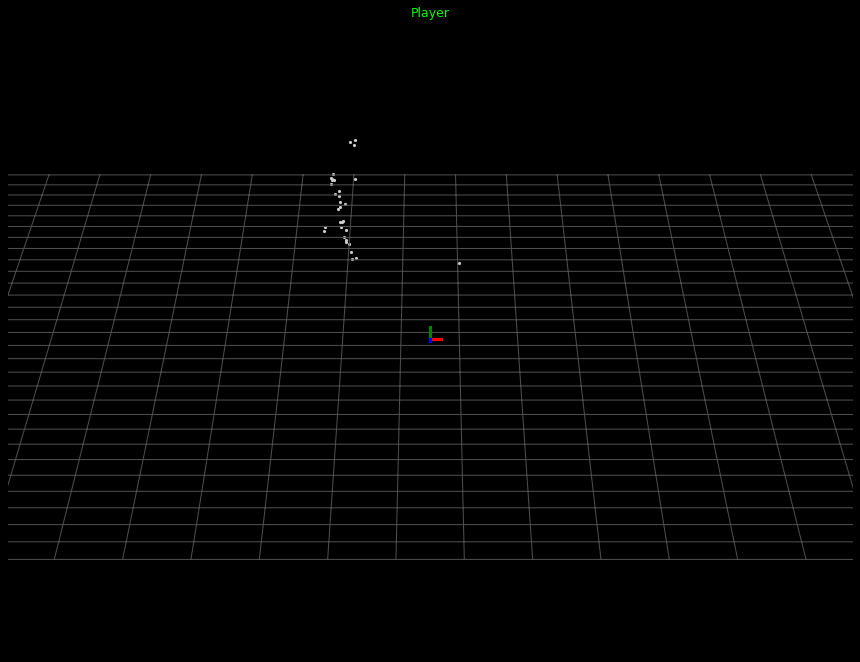

In [4]:
ktk.Player(markers)

Reconstructing kinematics
--------------------------

### Defining rigid body configurations using a static acquisition ###

One of the aims of the static trial is to have a sample where every marker is visible. We use this trial to define the rigid body configuration. A rigid body configuration is a list of markers that form a rigid body, along with their local position in the rigid body's reference frame.

For this example, we will create rigid bodies for the markers triads 'ArmR' and 'ForearmR'.

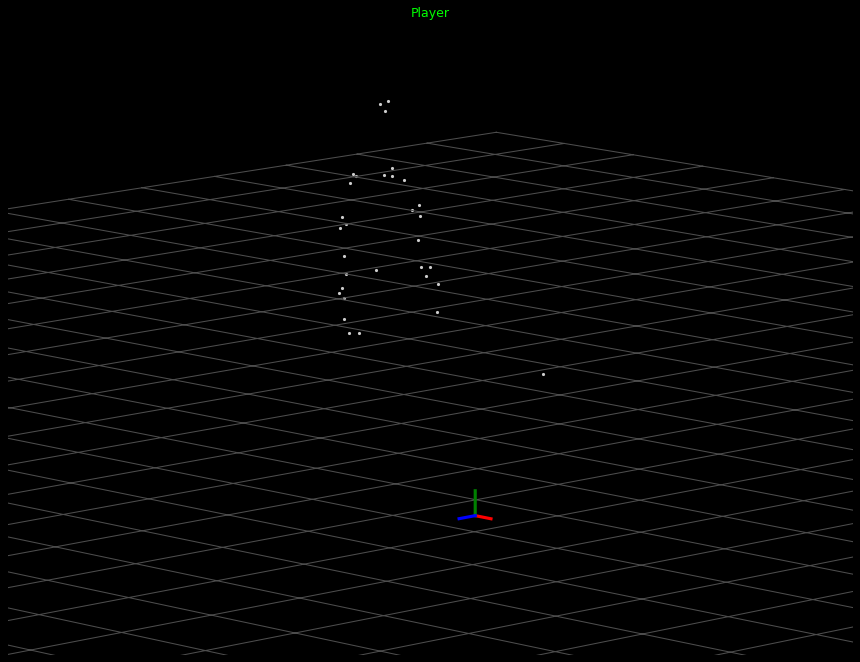

In [5]:
config = dict()                 # Will contain all configuration data.
config['RigidBodies'] = dict()  # Will contain all rigid body configurations.

# Read the static trial
markers = ktk.kinematics.read_n3d_file('data/kinematics/sample_static.n3d',
                                       labels=labels)

# Show this trial, just to inspect it
ktk.Player(markers, zoom=2, azimuth=0.8, elevation=0.16,
           translation=(0.2, -0.7))

In [6]:
# Create the rigid body configurations
config['RigidBodies']['ArmR'] = ktk.kinematics.create_rigid_body_config(
        markers, ['ArmR1', 'ArmR2', 'ArmR3'])

config['RigidBodies']['ForearmR'] = ktk.kinematics.create_rigid_body_config(
        markers, ['ForearmR1', 'ForearmR2', 'ForearmR3'])

The probe's rigid body configuration is created manually from its specifications. Each local point is expressed relative to a reference frame that is centered at the probe's tip.

In [7]:
config['RigidBodies']['Probe'] = {
        'MarkerNames': ['Probe1', 'Probe2', 'Probe3',
                        'Probe4', 'Probe5', 'Probe6'],
        'LocalPoints': np.array([[
                [2.1213,   2.1213,  2.0575,   2.1213,   1.7070,   1.7762],
                [-15.8328, 15.8508, 16.0096,  16.1204,  -15.5780, -15.6057],
                [86.4285,  86.4285, 130.9445, 175.4395, 175.3805, 130.8888],
                [1000,     1000,    1000,     1000,     1000,     1000]]]
                ) / 1000
        }

### Defining the virtual marker configurations based on probing acquisitions ###

In [8]:
config['VirtualMarkers'] = dict()  # Will contain all virtual marker configurations

Since this is a repetitive operation, we will create a new function that will be called for each virtual marker:

In [9]:
def process_probing_acquisition(file_name, rigid_body_name):

    # Load the markers
    markers = ktk.kinematics.read_n3d_file(file_name, labels=labels)

    # Calculate rigid body trajectories using these markers
    rigid_bodies = ktk.kinematics.register_markers(markers,
                                                   config['RigidBodies'])

    # Add the marker 'ProbeTip' in markers. This is the origin of the Probe
    # rigid body.
    markers.data['ProbeTip'] = rigid_bodies.data['Probe'][:, :, 3]
    markers.add_data_info('ProbeTip', 'Color', 'r')

    # Create the marker configuration
    return ktk.kinematics.create_virtual_marker_config(
            markers, rigid_bodies, 'ProbeTip', rigid_body_name)

Now, we can process every probing acquisition.

In [10]:
config['VirtualMarkers']['AcromionR'] = process_probing_acquisition(
        'data/kinematics/sample_probing_acromion_R.n3d', 'ArmR')

config['VirtualMarkers']['MedialEpicondyleR'] = process_probing_acquisition(
        'data/kinematics/sample_probing_medial_epicondyle_R.n3d', 'ArmR')

config['VirtualMarkers']['OlecraneR'] = process_probing_acquisition(
        'data/kinematics/sample_probing_olecrane_R.n3d', 'ForearmR')

config['VirtualMarkers']['RadialStyloidR'] = process_probing_acquisition(
        'data/kinematics/sample_probing_radial_styloid_R.n3d', 'ForearmR')

config['VirtualMarkers']['UlnarStyloidR'] = process_probing_acquisition(
        'data/kinematics/sample_probing_ulnar_styloid_R.n3d', 'ForearmR')

#### Defining segment configurations ####

This step is purely for visualization. Here, we define different segments
that will be shown in the Player.

In [11]:
config['Segments'] = dict()  # Will contain all segment definitions

config['Segments']['ArmR'] = {
        'Color': [1, 0.25, 0],
        'Links': [['AcromionR', 'MedialEpicondyleR'],
                  ['AcromionR', 'LateralEpicondyleR'],
                  ['AcromionR', 'OlecraneR']]
        }

config['Segments']['ForearmR'] = {
        'Color': [1, 0.5, 0],
        'Links': [['MedialEpicondyleR', 'RadialStyloidR'],
                  ['MedialEpicondyleR', 'UlnarStyloidR'],
                  ['LateralEpicondyleR', 'RadialStyloidR'],
                  ['LateralEpicondyleR', 'UlnarStyloidR'],
                  ['OlecraneR', 'RadialStyloidR'],
                  ['OlecraneR', 'UlnarStyloidR'],
                  ['UlnarStyloidR', 'RadialStyloidR']]
        }

Processing an experimental trial
--------------------------------

Now that we configured the rigid bodies and the virtual markers, we are ready to load an experimental trial, calculate the rigid body trajectories and recreate the virtual markers using these rigid bodies.

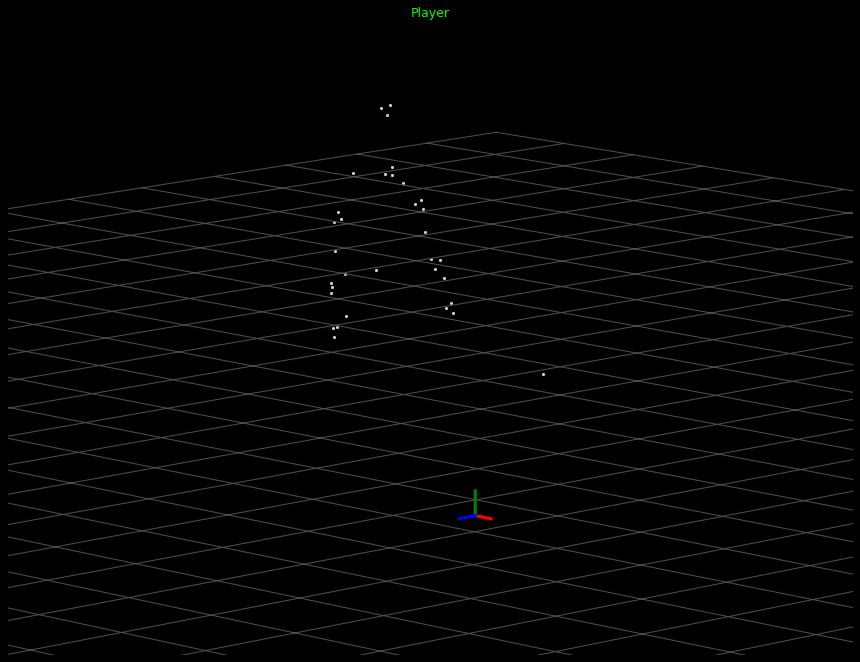

In [12]:
# Load the markers of the experimental trial
markers = ktk.kinematics.read_n3d_file(
        'data/kinematics/sample_propulsion.n3d', labels=labels)

# Show those markers in a player
ktk.Player(markers, zoom=2, azimuth=0.8, elevation=0.16,
           translation=(0.2, -0.7))

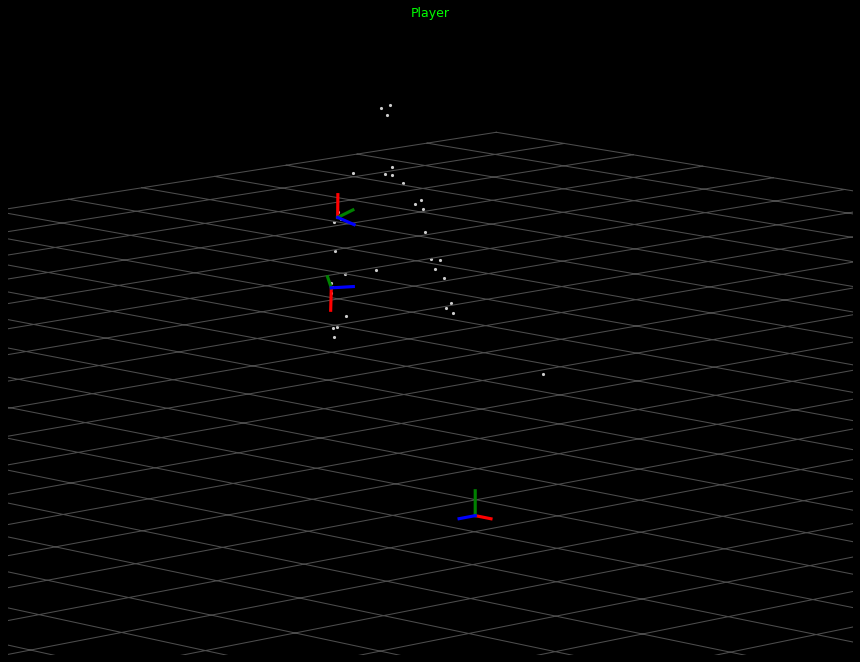

In [13]:
# Compute the rigid body trajectories
rigid_bodies = ktk.kinematics.register_markers(markers, config['RigidBodies'])

# Show those rigid bodies and markers in a player
ktk.Player(markers, rigid_bodies,
           zoom=2, azimuth=0.8, elevation=0.16, translation=(0.2, -0.7))

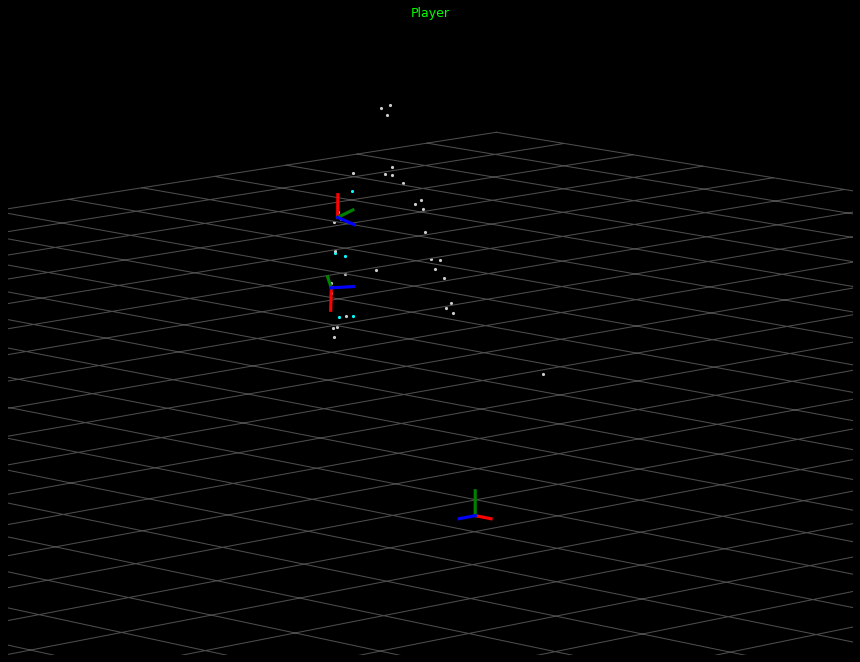

In [14]:
# Add the virtual markers

for virtual_marker in config['VirtualMarkers']:
    local_coordinates = config['VirtualMarkers'][virtual_marker]['LocalPoint']
    rigid_body_name = config['VirtualMarkers'][virtual_marker]['RigidBodyName']
    reference_frame = rigid_bodies.data[rigid_body_name]

    markers.data[virtual_marker] = ktk.geometry.get_global_coordinates(
            local_coordinates, reference_frame)

    # Assign a color for these virtual markers
    markers.add_data_info(virtual_marker, 'Color', 'c')

# Show the markers and rigid bodies in a player
ktk.Player(markers, rigid_bodies,
           zoom=2, azimuth=0.8, elevation=0.16, translation=(0.2, -0.7))

In [1]:
# Add the segments
ktk.Player(markers,
           segments=config['Segments'], zoom=2, azimuth=0.8, elevation=0.16,
           translation=(0.2, -0.7))

NameError: name 'ktk' is not defined

For more information on kinematics, please check the [API Reference](api/ktk.kinematics).